In [259]:
#setup
from igor2.binarywave import load as loadibw
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette = 'dark', style = 'white')

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300 #set dpi of figs for entire notebook

from scipy.stats import zscore
import statistics

from scipy.signal.windows import boxcar

In [2]:
from scipy.stats import fisher_exact as fisher
test_array = np.array([[10,13],
                       [18,35]])
fisher(test_array)

SignificanceResult(statistic=1.4957264957264957, pvalue=0.4490890125317595)

3 selected cells - for plot

per sweep amplitude values for those 3 cells - diary plot 3x10 pts

avg input size of responsive cells - histogram

failure rates of all cells - 28 pts

latency to peak of all responses - 28 pts

In [330]:
# funcs

def amps(stim,rec,t = 20, returnall = 0):
    
    '''
    Function that finds ALL the peaks in a given pair of stim and rec waves.
    
    Multiplies rec wave by 1e9 to convert to picoamps!
    
    Uses stimulus onset to find stims, and finds peak within window defined by t.
    amplitude calculated by subtracting peak from the baseline (mean of pre-first stim)
    
    Median may be better choice! check with olexiy.
    
    Parameters:
    
    stim      : expects wave (array)
    rec       : expects wave (array)
    
    Optional Parameters:
    
    t         : time duration of window in ms                     DEFAULT: 50
    returnall : if 1, returns amps, peaks, baseline, stim_locs    DEFAULT: 0

    Returns:
    
    amps      : peak amplitude of response                        (array)
    
    Optional Returns:
    
    peaks     : absolute value of peaks                           (array)
    baseline  : mean of the wave from start to first stim onset.  (float)
    stim_locs : stimulus onsets identified                        (list)
    
    '''
    delayms = 2
    
    freq = 50
    
    delayidx = delayms*freq
    
    rec = rec*1e9

    stim_locs = []
    for i in enumerate(stim):
        i = i[0]
        if i == 0:
            continue
        if stim[i+-1] < 1 and stim[i] > 1:
            stim_locs += [i]
            
    baseline = np.mean(rec[:stim_locs[0]])
    peaks = []

    for i in stim_locs:
        peaks += [np.min(rec[i+delayidx:i+t*freq])]
    
    peaks = np.array(peaks)
    amps = peaks - baseline
    
    if returnall:
        return amps, peaks, baseline, stim_locs
    
    return amps

# function that finds all peak amplitudes for a pair of waves

def zs(stim,rec,t = 50):
    
    freq = 50
    
    rec = rec*1e9

    stim_locs = []
    for i in enumerate(stim):
        i = i[0]
        if i == 0:
            continue
        if stim[i-1] < 1 and stim[i] > 1:
            stim_locs += [i]
            
    baseline_mean = np.mean(rec[:stim_locs[0]])
    baseline_std = np.std(rec[:stim_locs[0]])
    peaks = []
    zscores = []

    for i in stim_locs:
        peaks += [np.min(rec[i:i+t*freq])]
        zscores += [statistics.NormalDist(baseline_mean, baseline_std).zscore(np.min(rec[i:i+t*freq]))]
    peaks = np.array(peaks)
    zscores = np.array(zscores)
    amps = peaks - baseline_mean
    
    return zscores

# based on amps, finds latency of amplitudes

def latency(stim, rec, t = 20, delayms = 1):
    
    freq = 50
    
    delayidx = delayms*freq
    
    rec = rec*1e9

    stim_locs = []
    for i in enumerate(stim):
        i = i[0]
        if i == 0:
            continue
        if stim[i+-1] < 1 and stim[i] > 1:
            stim_locs += [i]
            
    baseline = np.mean(rec[:stim_locs[0]])
    #peaks = []
    peakidx = []
    for i in stim_locs:
        #peaks += [np.min(rec[i+delayidx:i+t*freq])]
        peakidx += [np.argmin(rec[i+delayidx:i+t*freq])]
    #peaks = np.array(peaks)
    peakidx = np.array(peakidx)
    #amps = peaks - baseline
    lats = peakidx / freq
    
    return lats


# protocolID: function that

def protocolID(waves, twop = False, tr20 = False):

    """
    Function that Identifies protocols based on number of sweeps,
    1  = 20 Train
    3  = Test Pulse (single)
    10 = Paired Pulse Protocol
    
    Parameters:
    
    waves     : dictionary of waves
    
    Optional Parameters:
    
    twop      : if TRUE, returns only two_pulse list     DEFAULT: False
    tr20      : if TRUE, returns only train_20p list     DEFAULT: False
    
    Returns:
    
    two_pulse  [list]
    train_20p  [list]
    one_pulse  [list]
    unassigned [list]

    """

    wavlst = list(waves.keys())

    train_20p = []
    one_pulse = []
    two_pulse = []
    unassigned = []
    dump = []

    # loop through the thingy
    for ele in wavlst:

        if len(dump) == 0: # if dump is empty, just add the element
            dump += [ele]

        else: #if dump is not empty, check if it's from the same series as previous

            if ele[2:4] == dump[-1][2:4]: #if same as previous, add to dump
                dump += [ele]

            elif len(dump) == 20: #if not same as previous and dump has 10, put it to two pulse
                two_pulse += [dump]
                dump = [ele]

            elif len(dump) == 6: # if not same as previous and not 10, but 3, one pulse
                one_pulse += [dump]
                dump = [ele]

            elif len(dump) == 2: # if not same as previous and not 10 or 3, train 20 pulses
                train_20p += [dump]
                dump = [ele]

            else: # if none of the above, put to unassigned
                unassigned += [dump]
                dump = [ele]

    # do something about sweeps remaining in dump at the end of the for loop

    if len(dump) == 0: #if same as previous, add to dump
        dump = []       
    elif len(dump) == 20: #if not same as previous and dump has 10, put it to two pulse
        two_pulse += [dump]
        dump = []      
    elif len(dump) == 6: # if not same as previous and not 10, but 3, one pulse
        one_pulse += [dump]
        dump = [] 
    elif len(dump) == 2: # if not same as previous and not 10 or 3, train 20 pulses
        train_20p += [dump]
        dump = []       
    else: # if none of the above, put to unassigned
        unassigned += [dump]
        dump = []
    
    if twop:
        return two_pulse
    elif tr20:
        return train_20p
    else:
        return two_pulse, one_pulse, train_20p, unassigned

def waveplot(stimID, recID, wavedata, paramdata = pd.DataFrame(), stim_c = 'b', stim_t = 1, stim_a = 1, rec_c = 'r', rec_t = 1, rec_a = 1,
             stim_text = "", rec_text = "", Rs = 0, Cs = 0, holding = 0,
              hratio = [1, 4], dims = (10,4), rec_ylim = (), freq = 50, autoscale = [0,0]):
    
    """
    Function that plots stim and recorded waves together.
    Plotted in Seaborn default theme.
    
    Parameters:
    
    stimID    : expects wave ID
    recID     : expects wave ID
    wavedata  : expects dataframe
        
    Optional Parameters:
    
    paramdata : expects dataframe, adds Rs, Cs and holding   DEFAULT: pd.DataFrame()
    
    > stim aesthetics
    stim_c    : color for stim wave and text                 DEFAULT:'b'
    stim_t    : line thickness                               DEFAULT: 1
    stim_a    : stim alpha                                   DEFAULT: 1
    
    > rec aesthetics
    rec_c     : color for rec wave and text                  DEFAULT:'r'
    rec_t     : line thickness                               DEFAULT: 1
    rec_a     : stim alpha                                   DEFAULT: 1
    
    > stim and rec text
    stim_text : text in stim plot
    rec_text  : additional text in stim plot in new line AFTER Rs, Cslow and holding
    Rs        : Rs value
    Cs        : Cslow value
    holding   : holding voltage
    
    > figure aesthetics
    hratio    : ratio of sizes of the stim and rec           DEFAULT: [1,5]
    dims      : dimensions of the plot in inches             DEFAULT: (2,20)
    rec_ylim  : tuple for scaling plot
    freq      : sampling frequency in KHz or samples/ms      DEFAULT: 50
    
    autoscale : scales plot [-[0]prestim:+[1] poststim] ms!  DEFAULT: [0,0]
 
    """
    
    # get waves from dataframe
    
    stim = wavedata[stimID].dropna()
    rec  = wavedata[recID].dropna()
    
    # if paramdata is provided
    if paramdata.empty == False:
        holding = paramdata.loc[recID][0]
        Cs      = paramdata.loc[recID][1][:-1]
        Rs      = paramdata.loc[recID][2][:-1]
        
    
    time = 0.001*np.arange(0,stim.shape[0]+1)/freq #in seconds, can add if statement for ms later

    #scaling routine
    
    start = 0 #default minimum
    end = time.shape[0]-1 #default maximum
    
    if autoscale != [0,0]:
        stim_locs = []
        for i in enumerate(stim):
            i = i[0]
            if i == 0:
                continue
            if stim[i-1] < 1 and stim[i] > 1:
                stim_locs += [i]
                
        start = stim_locs[0] - freq*autoscale[0] #given milliseconds prior to first stim
        end = stim_locs[-1] + freq*autoscale[1]  #given milliseconds post last stim (from start of last stim)
    
    sns.set_theme()
    plt.subplots(2,1,gridspec_kw={'height_ratios': hratio}) #ratio of stim and rec plot sizes
    plt.subplots_adjust(hspace=0) #squeezes plots together
    
    #build rec text label
    if rec_text:
        rec_text = "\n"+rec_text
    if Cs != 0:
        rec_text = "\n$C_{slow}$ "+str(Cs)+"pF"+rec_text
    if Rs != 0:
        rec_text = "\n$R_{s}$ "+str(Rs)+"MOhm"+rec_text
    if holding != 0:
        rec_text = str(holding)+" mV"+rec_text
        
    rec_y = np.min(rec*1e9) # because yloc for rec_text will change if ylim is updated
    

    #plot stim
    plt.subplot(2,1,1)
    plt.plot(time[start:end], stim[start:end], color = stim_c, linewidth = stim_t, alpha = stim_a)
    if stim_text:
        plt.text(time[end],np.max(stim),stim_text, horizontalalignment='right', verticalalignment='top', color = stim_c)
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    plt.ylim(-0.2,10)
    
    #plot recorded channel
    plt.subplot(2,1,2)
    plt.plot(time[start:end], rec[start:end]*1e9, color = rec_c, linewidth = rec_t, alpha = rec_a)
    plt.ylabel("nA")
    plt.xlabel("s")
    #plt.gca().set_xticks([])
    if rec_ylim:
        plt.ylim(rec_ylim)
        rec_y = rec_ylim[0] # update yloc if ylim present
    if rec_text:
        plt.text(time[end],rec_y,rec_text, horizontalalignment='right', verticalalignment='bottom', color = rec_c)
        
    plt.gcf().set_size_inches(dims) #sets dimensions of the plot in inches, change dpi across notebook!

# AVGPLOT: Plot a series of sweeps along with an average trace

def avgplot(series, wavedata, paramdata = pd.DataFrame(), theme = False, 
            stim_c = 'b', stim_t = 1, stim_a = 1, rec_c = 'r', rec_t = 1, rec_a = 0.5, avg_c = "black", avg_t = 1, avg_a = 1,
             stim_text = "", rec_text = "", Rs = 0, Cs = 0, holding = 0,
              hratio = [1, 4], dims = (10,4), rec_ylim = (-0.5,0.05), freq = 50, autoscale = [0,0]):
    
    """
    Function that plots an entire series, with an average trace.
    Plotted in Seaborn default theme.
    
    Parameters:
    
    series    : expects list of waves, stim and rec sequence
    wavedata  : expects pandas dataframe of all the wavedata, wave IDs correspond to columns.
    
    Optional Parameters:
    
    paramdata : expects dataframe, adds Rs and Cs values     DEFAULT: pd.DataFrame()
    theme     : Changes sns.set_theme(style)                 DEFAULT: False
    
    stim aesthetics
    stim_c    : color for stim wave and text                 DEFAULT:'b'
    stim_t    : line thickness                               DEFAULT: 1
    stim_a    : stim alpha                                   DEFAULT: 1
    
    rec aesthetics
    rec_c     : color for rec wave and text                  DEFAULT:'r'
    rec_t     : line thickness                               DEFAULT: 1
    rec_a     : rec alpha                                    DEFAULT: 0.4
    
    avg aesthetics
    avg_c     : color for rec wave and text                  DEFAULT:'black'
    avg_t     : line thickness                               DEFAULT: 1
    avg_a     : avg  alpha                                   DEFAULT: 1
    
    stim and rec text
    stim_text : text in stim plot
    rec_text  : additional text in stim plot in new line AFTER Rs, Cslow and holding
    Rs        : Rs value
    Cs        : Cslow value
    holding   : holding voltage
    
    figure aesthetics
    hratio    : ratio of sizes of the stim and rec           DEFAULT: [1,5]
    dims      : dimensions of the plot in inches             DEFAULT: (2,20)
    rec_ylim  : tuple for scaling plot
    freq      : sampling frequency in KHz or samples/ms      DEFAULT: 50
    
    autoscale : scales plot [-[0]prestim:+[1] poststim] ms!  DEFAULT: [0,0]

    """
    
     
    # find stim waves
    stims = series[::2]
    stimdf = wavedata[stims].dropna()
    
    # find rec waves
    recs = series[1::2]
    recdf = wavedata[recs].dropna()
    
    # if paramdata is provided
    if paramdata.empty == False:
        holding = paramdata.loc[recs[0]][0]
        Cs      = paramdata.loc[recs[0]][1][:-1]
        Rs      = paramdata.loc[recs[0]][2][:-1]
    
    # find avg trace
    avg = wavedata[recs].dropna().mean(axis=1) 
    
    #conversion to time in seconds using sampling frequency
    time = 0.001*np.arange(0,avg.shape[0]+1)/freq #in seconds, can add if statement for ms later
    
    #scaling routine
    start = recdf.index[0] #default minimum
    end = time.shape[0]-1-start #default maximum
    
    if autoscale != [0,0]:
        stim_locs = []
        for i in enumerate(stimdf[stims[0]]): # find stim starts using 1st stimulus wave
            i = i[0]
            if i == 0:
                continue
            if stimdf[stims[0]][i+start-1] < 1 and stimdf[stims[0]][i+start] > 1:
                stim_locs += [i]
                
        start = stim_locs[0] - freq*autoscale[0] #given milliseconds prior to first stim
        end = stim_locs[-1] + freq*autoscale[1]  #given milliseconds post last stim (from start of last stim)
    
    if theme:
        sns.set_theme(style="white", palette = 'deep')
    else:
        sns.set_theme()
        
    plt.subplots(2,1,gridspec_kw={'height_ratios': hratio}) #ratio of stim and rec plot sizes
    if theme == False:
        plt.subplots_adjust(hspace=0) #squeezes plots together
    
    
    #build rec text label
    if rec_text:
        rec_text = "\n"+rec_text
    if Cs != 0:
        rec_text = "\n$C_{slow}$ "+str(Cs)+"pF"+rec_text
    if Rs != 0:
        rec_text = "\n$R_{s}$ "+str(Rs)+"MOhm"+rec_text
    if holding != 0:
        rec_text = str(holding)+" mV"+rec_text
        
    rec_y = np.min(recdf[start:end].min()*1e9) # because yloc for rec_text will change if ylim is updated
    
    
    
    #plot stim
    plt.subplot(2,1,1)
    # for loop to overlay all stim traces
    for ele in stims:
            plt.plot(time[start:end], stimdf[ele][start:end], color = stim_c, linewidth = stim_t, alpha = stim_a)
    # place stim text only once     
    if stim_text:
        plt.text(time[end],10,stim_text, horizontalalignment='right', verticalalignment='top', color = stim_c)
    # some aesthetics
    if theme:
        sns.despine(top=True, right=True, left=True, bottom=True)
    plt.xlim(time[start],time[end])
    plt.gca().set_xticks([]) 
    plt.gca().set_yticks([])
    plt.ylim(-0.2,10)
    
    #plot recorded channel
    plt.subplot(2,1,2)
    #for loop to overall all rec traces
    for ele in recs:
            plt.plot(time[start:end], recdf[ele][start:end]*1e9, color = rec_c, linewidth = rec_t, alpha = rec_a)
            
    plt.plot(time[start:end], avg[start:end]*1e9, color = avg_c, linewidth = avg_t, alpha = avg_a)
        
    plt.ylabel("nA")
    plt.xlabel("s")
    plt.xlim(time[start],time[end])
    
    if rec_ylim[0] < rec_y or rec_ylim != (-0.5,0.05):
        plt.ylim(rec_ylim)
        rec_y = rec_ylim[0] # update yloc if ylim present
    else:
        rec_y = rec_y - 0.1
        plt.ylim(rec_y,0)
    
    if theme:
        rec_y = rec_y + 0.025 
        
    if rec_text:
        plt.text(time[end],rec_y,rec_text, horizontalalignment='right', verticalalignment='bottom', color = rec_c)
    
    if theme:
        plt.gca().spines["left"].set_visible(True)
        plt.gca().spines["bottom"].set_visible(True)
        
        plt.gca().tick_params(bottom=True, left=True)
    else:
        sns.despine(top=True, right=True, left=True, bottom=True)
        
    plt.gcf().set_size_inches(dims) #sets dimensions of the plot in inches, change dpi across notebook!

In [3]:
#list of directories of responding neurons

dirs = ["C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/041122M#FW1064/A/A_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122C/091122C_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122H/091122H_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122I/091122I_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122C/101122C_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122D/101122D_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122E/101122E_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122D/111122D_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122F/111122F_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/221222M#1046/Dec2222C/Dec2222C_Waves"]


In [4]:
#list of directories of all curated neurons

dirs = ["C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/041122M#FW1064/A/A_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122C/091122C_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122H/091122H_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122I/091122I_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122J/091122J_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122K/091122K_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122A/101122A_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122C/101122C_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122D/101122D_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122E/101122E_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122H/101122H_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122I/101122I_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122J/101122J_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122A/111122A_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122C/111122C_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122D/111122D_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122E/111122E_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122F/111122F_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122H/111122H_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122I/111122I_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/201222M#1049/Dec2022G/Dec2022G_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/221222M#1046/Dec2222A/Dec2222A_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/221222M#1046/Dec2222C/Dec2222C_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/221222M#1046/Dec2222D/Dec2222D_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/231222M#1048/Dec2322A/Dec2322A_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/231222M#1048/Dec2322B/Dec2322B_Waves",
        "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/231222M#1048/Dec2322D/Dec2322D_Waves"]

#         "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/201222M#1049/Dec2022C/Dec2022C_Waves", # discarded for noise

ns   = [1, 3,2,1,1,0, 3,1,0,3,0,2,2, 2,0,2,2,5,1,0, 0, 2,0,1, 2,1,1] # which series of 2p
resp = [1, 1,1,1,0,1, 0,1,1,1,0,0,0, 0,0,1,0,1,0,0, 0, 0,1,0, 0,1,0] # responder by eye

## Details of selected cells

In [289]:
selected = ['C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122C/101122C_Waves', #PERFECT
            "C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122F/111122F_Waves", #FAILURES
            'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122H/101122H_Waves'] #NON RESPONDER
nselect = [1, 5, 0]

In [290]:
plotdata = []

for i, wave_dir in enumerate(selected):
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)
    
    twop = protocolID(boxcardata, twop = True)

    plotdata += [boxcardata[twop[nselect[i]]]]

In [291]:
stim = plotdata[0][plotdata[0].columns[0]]
stim_locs = []
for i in enumerate(stim):
        i = i[0]
        if i == 0:
            continue
        if stim[i+-1] < 1 and stim[i] > 1:
            stim_locs += [i]
            
xlims = [stim_locs[0]-50*50,stim_locs[0]+50*150]

In [292]:
avgs = []

for cell in plotdata:
    wavlst = cell.columns
    dump = []
    for wave in wavlst:
        if wave[-1] != '1':
            dump += [cell[wave]]
    dump = np.array(dump)
    avgs += [np.average(dump, axis = 0)]

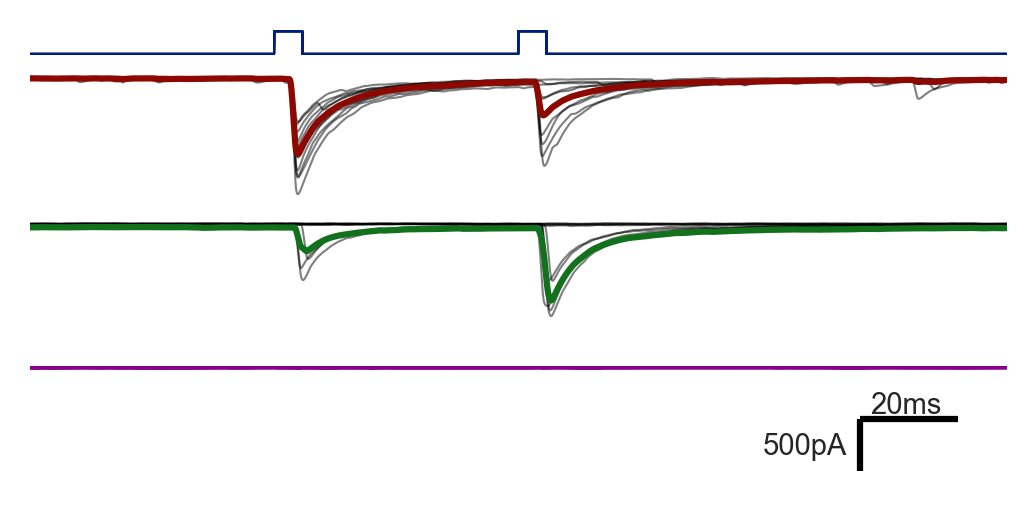

In [293]:
sns.set_style("white")
plt.subplots(4,1,gridspec_kw={'height_ratios': [1,5,5,5]})
#plt.subplots_adjust(hspace = 0)

ylims = [-1.2e-9,0]
#xlims = [23000,32000]

for wav in plotdata[0].columns:
    if wav[-1] == '1':
        plt.subplot(4,1,1)
        plt.plot(plotdata[0][wav]>1, c = 'b', linewidth = 0.5)
        plt.xticks([])
        plt.xlim(xlims)
        plt.yticks([])
        
    else:
        plt.subplot(4,1,2)
        plt.plot(plotdata[0][wav], c = 'black', linewidth = 0.5, alpha = 0.5)
        plt.xticks([])
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.yticks([])
plt.plot(avgs[0], c = 'r')
        
for wav in plotdata[1].columns:
    if wav[-1] != '1':
        plt.subplot(4,1,3)
        plt.plot(plotdata[1][wav]/2, c = 'black', linewidth = 0.5, alpha = 0.5)
        plt.xticks([])
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.yticks([])
plt.plot(avgs[1], c = 'g')
        
for wav in plotdata[2].columns:
    if wav[-1] != '1':
        plt.subplot(4,1,4)
        plt.plot(plotdata[2][wav], c = 'black', linewidth = 0.5, alpha = 0.5)
        plt.ylim(ylims)
        plt.xlim(xlims)
        plt.xticks([])
        plt.yticks([])
        
plt.plot(avgs[2], c = 'darkmagenta')
plt.hlines(- 0.5e-9,xlims[1]-50*30,xlims[1]-50*10, color = 'black')
plt.text(xlims[1]-50*28, - 0.45e-9, "20ms", fontname = 'Arial', fontsize = 7)

plt.vlines(xlims[1]-50*30, -0.5e-9, - 1e-9, color = 'black')
plt.text(xlims[1]-50*50, - 0.85e-9, "500pA", fontname = 'Arial', fontsize = 7)
sns.despine(left = 'True', bottom = 'true')
plt.gcf().set_size_inches(4.2,2)
plt.savefig(r"C:\Users\njana\Desktop\ephysfig1\example_traces.svg")

## Diary plot for selected cells

In [294]:
plotdata = []

for i, wave_dir in enumerate(selected):
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)
    
    twop = protocolID(boxcardata, twop = True)
    wavlist = twop[nselect[i]]
    dump = []
    
    for i in range(int(len(wavlist)/2)):
        amp = -1000*amps(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        dump += [amp[0]]
        
    plotdata += [dump]
    

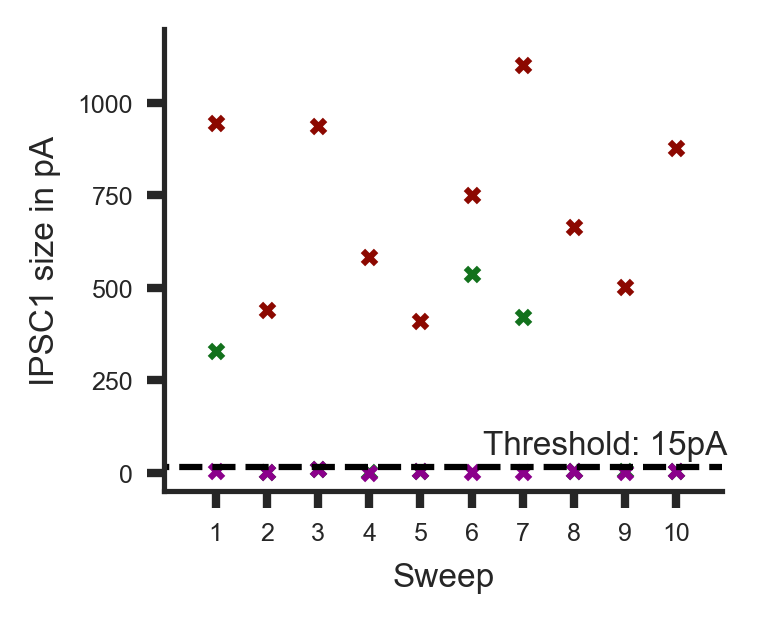

In [446]:
sns.set_style('ticks') 
plt.scatter(np.arange(1,11),plotdata[0], c = 'r', marker = 'x', s = 10)
plt.scatter(np.arange(1,11),np.array(plotdata[1])/2, c = 'g', marker = 'x', s = 10)
plt.scatter(np.arange(1,11),plotdata[2], c = 'darkmagenta', marker = 'x', s = 10)
plt.hlines(15,-1,11, color = 'black', linestyles = 'dashed')
plt.xlim(0,10.9)
plt.xticks(np.arange(1,11),labels = np.arange(1,11), fontsize = 6, fontname = 'Arial')
plt.yticks(fontsize = 6, fontname = 'Arial')
plt.ylim(-50,1200)
sns.despine()
plt.ylabel("IPSC1 size in pA", fontname = 'Arial', fontsize = 8)
plt.xlabel("Sweep", fontname = 'Arial', fontsize = 8)
plt.text(11,50,"Threshold: 15pA", ha = 'right', fontname = 'Arial', fontsize = 8)
plt.gca().tick_params('both', length=4, width=2, which='major')


plt.gcf().set_size_inches(2.4,2)
plt.savefig(r"C:\Users\njana\Desktop\ephysfig1\diary plot.svg")

## amplitudes of all responses, latencies of respones, failure rates per cell

In [442]:
responders = ['C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/041122M#FW1064/A/A_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122C/091122C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122H/091122H_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122I/091122I_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122K/091122K_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122C/101122C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122D/101122D_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122E/101122E_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122D/111122D_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122F/111122F_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/221222M#1046/Dec2222C/Dec2222C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/231222M#1048/Dec2322B/Dec2322B_Waves']

succ_amps = []

succ_lats = []

failure_rate = []

for ele in enumerate(responders):
    i = ele[0]
    wave_dir = ele[1]
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)
    
    twop = protocolID(boxcardata, twop = True)

    wavlist = twop[ns[i]]
    
    failcount = 0
    for i in range(int(len(wavlist)/2)):
        amp = -1000*amps(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        lat = latency(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        
        if amp[0] > 15:
            succ_amps += [amp[0]]
            succ_lats += [lat[0]]
        else:
            failcount += 1
        if amp[1] > 20:
            continue
            #succ_amps += [amp[1]]
            #succ_lats += [lat[1]]
        else:
            failcount += 1
    failure_rate += [failcount/20]
        

In [443]:
frate = [13,  7, 15, 16, 10, 19,  8, 12, 19, 11,  8,  6]

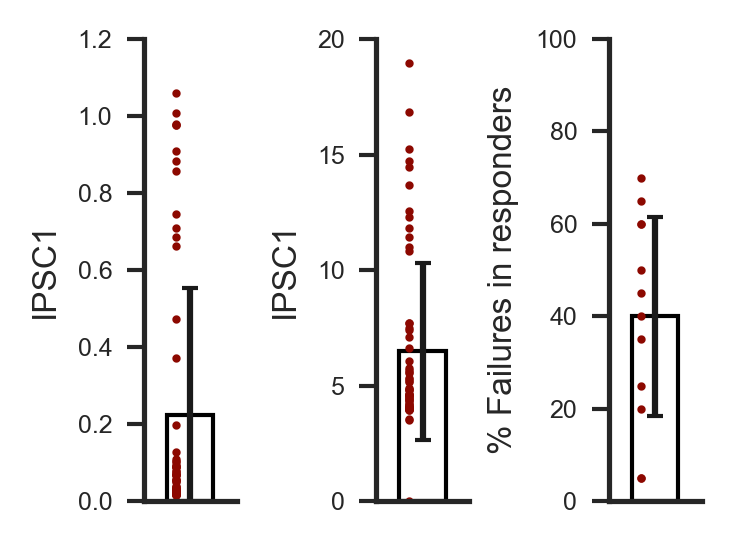

In [444]:
sns.set_style('ticks')
plt.subplots_adjust(wspace = 1.5)

plt.subplot(1,3,1)

plt.bar(x = 1, height =  np.mean(succ_amps)/1000, yerr = np.std(succ_amps)/1000 , capsize = 2, fill = False, edgecolor = 'black', width = 1)
plt.scatter(x = np.ones(len(succ_amps))*0.7, y = np.array(succ_amps)/1000, s = 1, color = 'r')
plt.xlim(0,2)
#plt.boxplot(np.array(succ_amps)/1000, flierprops={'markersize': 1}, widths= 0.8)
#sns.stripplot(y = np.array(succ_amps)/1000, s = 2)

plt.yticks(fontname = 'Arial', fontsize = '6')
plt.gca().tick_params('both', length=4, width=1, which='major')
plt.ylabel("IPSC Amplitude in nA",fontname = 'Arial', fontsize = '8')
plt.ylabel("IPSC1",fontname = 'Arial', fontsize = '8')
plt.yticks((0,0.2,0.4,0.6,0.8,1.0,1.2))
plt.ylim(0,1.2)
plt.xticks([])

plt.subplot(1,3,2)
#sns.stripplot(succ_lats, s = 2)
#plt.boxplot(succ_lats, flierprops={'markersize': 1}, widths= 0.8)
plt.bar(x = 1, height =  np.mean(succ_lats), yerr = np.std(succ_lats) , capsize = 2, fill = False, edgecolor = 'black', width = 1)
plt.scatter(np.ones(len(succ_lats))*0.7, succ_lats, s = 1, color = 'r')
plt.xlim(0,2)

plt.yticks(fontname = 'Arial', fontsize = '6')
plt.gca().tick_params('both', length=4, width=1, which='major')
plt.ylabel("IPSC latency in ms",fontname = 'Arial', fontsize = '8')
plt.ylabel("IPSC1",fontname = 'Arial', fontsize = '8')
plt.ylim(0,20)
plt.xticks([])

plt.subplot(1,3,3)
#sns.stripplot((20 - np.array(frate))*5, s = 2)
#plt.boxplot((20 - np.array(frate))*5, widths = 0.8)
plt.bar(x = 1, height = np.mean((20 - np.array(frate))*5), yerr = np.std((20 - np.array(frate))*5), capsize = 2, fill = False, edgecolor = 'black', width = 1)
plt.scatter(x = np.ones(len(frate))*0.7, y = (20 - np.array(frate))*5, s = 1, color = 'r')
plt.xlim(0,2)
plt.yticks(fontname = 'Arial', fontsize = '6')
plt.gca().tick_params('both', length=4, width=1, which='major')
plt.ylabel("% Failures in responders",fontname = 'Arial', fontsize = '8')
plt.xticks([])
plt.ylim(0,100)

sns.despine()
plt.gcf().set_size_inches(2.4,2)
plt.savefig(r"C:\Users\njana\Desktop\ephysfig1\bar plots.svg")

In [575]:
np.std((20 - np.array(frate))*5)

21.50581316760657

## Histogram of amplitudes

In [440]:
responders = ['C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/041122M#FW1064/A/A_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122C/091122C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122H/091122H_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122I/091122I_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122K/091122K_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122C/101122C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122D/101122D_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122E/101122E_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122D/111122D_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122F/111122F_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/221222M#1046/Dec2222C/Dec2222C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#2_Dec23/231222M#1048/Dec2322B/Dec2322B_Waves']

succ_ampavg = []

for ele in enumerate(responders):
    i = ele[0]
    wave_dir = ele[1]
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)
    
    twop = protocolID(boxcardata, twop = True)

    wavlist = twop[ns[i]]
    
    dump = []
        
    for i in range(int(len(wavlist)/2)):
        amp = -1000*amps(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        lat = latency(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        
        if amp[0] > 15:
            dump += [amp[0]]
        
    succ_ampavg += [np.average(dump)]

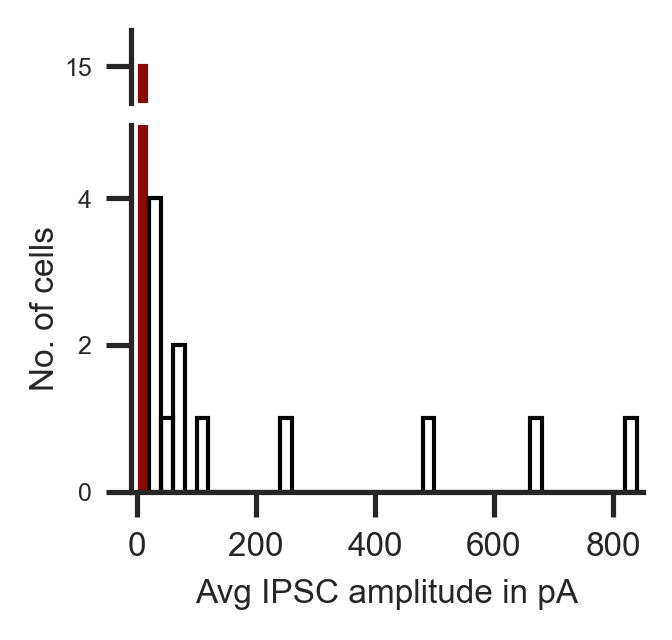

In [537]:
plt.subplots(2,1,gridspec_kw={'height_ratios': [1,5]})
plt.subplots_adjust(hspace = 0.1)

plt.subplot(2,1,1)
plt.bar(10, height = 15 ,width = 10, color = 'r', edgecolor = 'r') # non-responders
plt.hist(succ_ampavg, bins = np.arange(0,1000,20), width = 20, edgecolor = "black", fill = False)
plt.xticks([])
plt.yticks([15],[15],fontname = 'Arial', fontsize = 6)
plt.ylim(14,16)
plt.gca().spines.bottom.set_visible(False)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.xlim(-10,850)

plt.subplot(2,1,2)

plt.bar(10, height = 15 ,width = 10, color = 'r', edgecolor = 'r') # non-responders
plt.hist(succ_ampavg, bins = np.arange(0,1000,20), width = 20, edgecolor = "black", fill = False)
plt.xticks(np.arange(0,900,200),np.arange(0,900,200), fontname = 'Arial', fontsize = 8)
plt.yticks(fontname = 'Arial', fontsize = 6)
plt.ylabel("No. of cells",fontname = 'Arial', fontsize = 8)
plt.xlabel("Avg IPSC amplitude in pA",fontname = 'Arial', fontsize = 8)
plt.gca().spines.top.set_visible(False)
plt.gca().spines.right.set_visible(False)
plt.ylim(0,5)
plt.xlim(-10,850)
#sns.despine()

plt.gcf().set_size_inches(2.2,2)

plt.savefig(r"C:\Users\njana\Desktop\ephysfig1\histogram.svg")

## pie chart

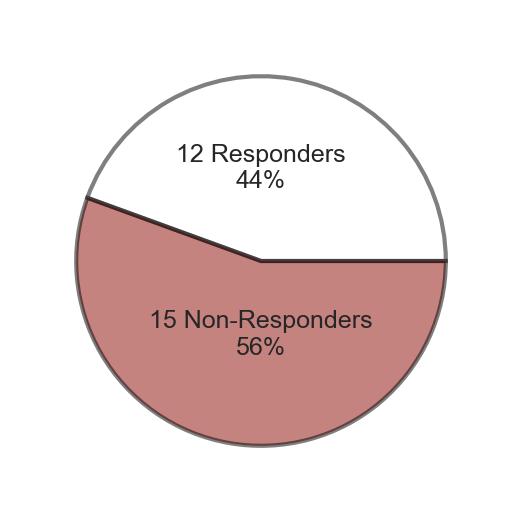

In [568]:
sns.set_style('ticks')

plt.gcf().set_size_inches(2,2)

plt.pie([12,15],colors = ["white","r"], 
        wedgeprops= {"edgecolor":"black",
                     'linewidth': 1,
                     'antialiased': True,
                     'alpha': 0.5})
plt.text(0, 0.5, "12 Responders\n44%", ha = 'center', va = 'center', fontsize = 6, fontname = 'Arial')
plt.text(0, -0.4, "15 Non-Responders\n56%", ha = 'center', va = 'center', fontsize = 6, fontname = 'Arial')

plt.savefig(r"C:\Users\njana\Desktop\ephysfig1\pie.svg")

---
---

In [10]:
# amp threshold and latency consistency sorting

'''

cell wise latency

collect input amps in cell wise fashion
collect latency in cell wise fasion

(1) find input amp for each cell p1, p2
(2) find latencies for each cell p2, p2
(3) if inputs are above threshold, count latency
(4) plot latencies first(?)


(5) find variance of latencies or find max-min difference
(6) establish a threshold for selecting out that one goddamn cell


'''

amps1 = []
amps2 = []
lats1 = []
lats2 = []

for ele in enumerate(dirs):
    i = ele[0]
    wave_dir = ele[1]
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)
    
    twop = protocolID(boxcardata, twop = True)

    wavlist = twop[ns[i]]
    
    p1a = []
    p1l = []
    p2a = []
    p2l = []
    
    for i in range(int(len(wavlist)/2)):
        amp = -1000*amps(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        lat = latency(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])

        p1a += [amp[0]]
        p2a += [amp[1]]
        p1l += [lat[0]]
        p2l += [lat[1]]
        
    amps1 += [np.array(p1a)]
    amps2 += [np.array(p2a)]
    lats1 += [np.array(p1l)]
    lats2 += [np.array(p2l)]

([<matplotlib.axis.XTick at 0x19535559750>,
 [Text(1, 0, '0'),
  Text(7, 0, '1'),
  Text(13, 0, '2'),
  Text(19, 0, '3'),
  Text(25, 0, '4'),
  Text(31, 0, '5'),
  Text(37, 0, '6'),
  Text(43, 0, '7'),
  Text(49, 0, '8'),
  Text(55, 0, '9'),
  Text(61, 0, '10'),
  Text(67, 0, '11'),
  Text(73, 0, '12'),
  Text(79, 0, '13'),
  Text(85, 0, '14'),
  Text(91, 0, '15'),
  Text(97, 0, '16'),
  Text(103, 0, '17'),
  Text(109, 0, '18'),
  Text(115, 0, '19'),
  Text(121, 0, '20'),
  Text(127, 0, '21'),
  Text(133, 0, '22'),
  Text(139, 0, '23'),
  Text(145, 0, '24'),
  Text(151, 0, '25'),
  Text(157, 0, '26')])

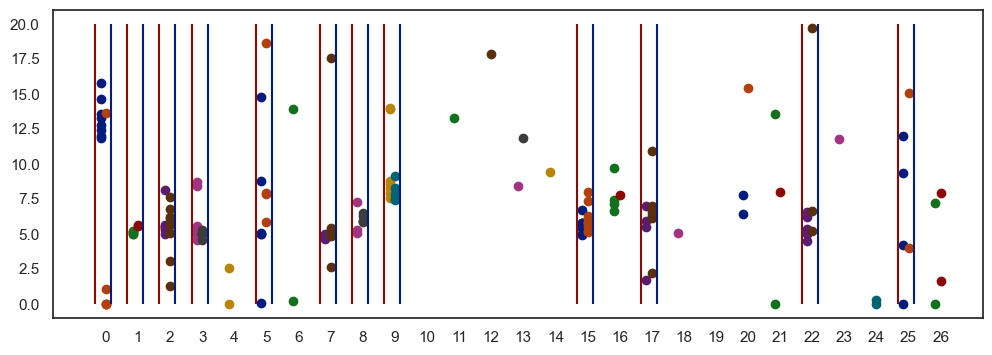

In [11]:
#plot latencies peak 1
c = 0
for i in range(27):
    lats2plot = lats1[i][amps1[i]>15]
    plt.scatter(x = np.ones(len(lats2plot))*c, y = lats2plot)
    if resp[i]:
        plt.vlines(x = c-1, ymin = 0, ymax = 20, color = 'r')
    c += 1
    lats2plot = lats2[i][amps2[i]>20]
    plt.scatter(x = np.ones(len(lats2plot))*c, y = lats2plot)   
    if resp[i]:
        plt.vlines(x = c+1, ymin = 0, ymax = 20, color = 'b')
    c += 5

plt.gcf().set_size_inches(12,4)
plt.xticks(np.arange(1,160,6),np.arange(0,27,1))

In [12]:
success = []


for ele in enumerate(dirs):
    
    i = ele[0]
    wave_dir = ele[1]
    
    #if resp[i]:

    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
                waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)

    counter = 0

    twop = protocolID(boxcardata, twop = True)

    wavlist = twop[ns[i]]
    for i in range(int(len(wavlist)/2)):
        amp = -1*amps(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        lats = latency(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        if amp[0] > 0.015:
                counter += 1
        if amp[1] > 0.020:
                counter += 1
    success += [counter]

In [939]:
p1amps = []
p2amps = []
p1avgs = []
p2avgs = []


for ele in enumerate(dirs):
    i = ele[0]
    wave_dir = ele[1]
    
    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
        waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)
    
    p1 = []
    p2 = []
    p1zs = []
    p2zs = []
    lat1 = []
    lat2 = []
    
    twop = protocolID(boxcardata, twop = True)
    
    wavlist = twop[ns[i]]
    
    for i in range(int(len(wavlist)/2)):
        amp = -1*amps(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        zss = zs(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        lats = latency(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        p1 += [amp[0]]
        p2 += [amp[1]]
        p1zs += [zss[0]]
        p2zs += [zss[1]]
        lat1 += [lats[0]]
        lat2 += [lats[1]]
    
    p1amps += p1
    p2amps += p2
    
    
    if resp[i]:
            p1avgs += [np.mean(np.array(p1)[np.abs(np.array(p1zs))>3])]
            p2avgs += [np.mean(np.array(p2)[np.abs(np.array(p2zs))>3])]
    else:
        p1avgs += [np.mean(p1)]
        p2avgs += [np.mean(p2)]

C:\Users\njana\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\njana\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [13]:
success = []


for ele in enumerate(dirs):
    
    i = ele[0]
    wave_dir = ele[1]
    
    #if resp[i]:

    #load every wave into a dictionary
    waves = {}
    for filename in os.listdir(wave_dir):
                waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
    #convert into a nice structured dataframe
    wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
    boxcardata = wavedata.rolling(50).mean()

    freq = 50 #per ms (50 KHz)

    counter = 0

    twop = protocolID(boxcardata, twop = True)

    wavlist = twop[ns[i]]
    for i in range(int(len(wavlist)/2)):
        amp = -1*amps(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        lats = latency(boxcardata[wavlist[i*2]],boxcardata[wavlist[i*2+1]])
        if amp[0] > 0.015:
                counter += 1
        if amp[1] > 0.020:
                counter += 1
    success += [counter]

In [297]:
success = np.array(success)
len(success[success>5])

12

In [332]:
success[success > 5]

array([13,  7, 15, 16, 10, 19,  8, 12, 19, 11,  8,  6])

In [15]:
dirs = np.array(dirs)

In [296]:
dirs[success > 5]

array(['C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/041122M#FW1064/A/A_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122C/091122C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122H/091122H_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122I/091122I_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/091122M#FW1065/091122K/091122K_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122C/101122C_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122D/101122D_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/101122M#FW1061/101122E/101122E_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1066/111122D/111122D_Waves',
       'C:/users/njana/Desktop/ephys/VMHvl Shell Inputs/#1_Nov23/111122M#FW1

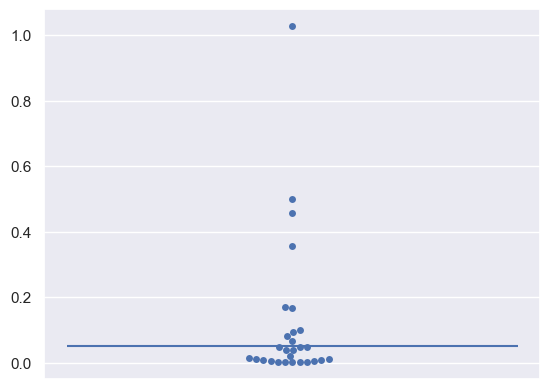

In [823]:
sns.swarmplot(p2avgs)
#plt.ylim(-0.02,0.5)
plt.hlines(y = 0.05, xmin = -1, xmax = 1)

In [793]:
p1avgs = np.array(p1avgs)
len(p2avgs[p2avgs>0.015])

10

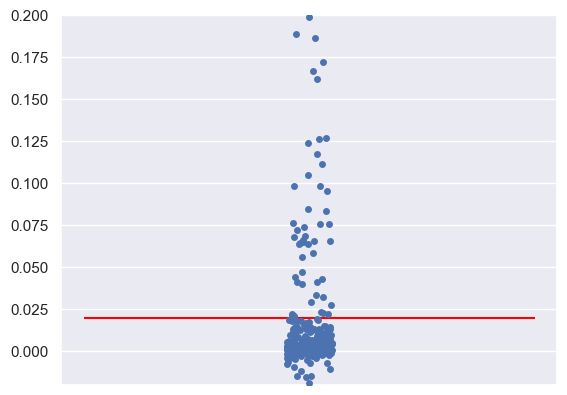

In [829]:
sns.stripplot(p2amps)
plt.ylim(-0.02,0.2)
plt.hlines(y = 0.020, xmin = -1, xmax = 1, color = 'red')

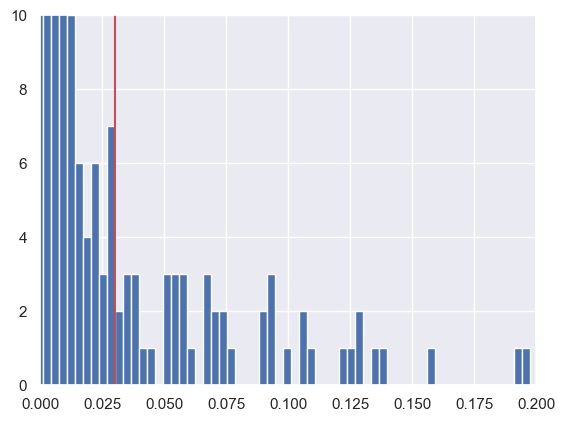

In [790]:
plt.hist(p1amps, bins = 350)
plt.ylim(0,10)
plt.xlim(0,0.2)
plt.vlines(0.030, 0,100, color = 'r')

In [771]:
p2avgcp = p2avgs
p2cp = np.array(p2amps)

p2avgcp[p2avgcp < 0.05] = 0

p2cp[p2cp < 0.05] = 0

<Axes: >

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 58.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


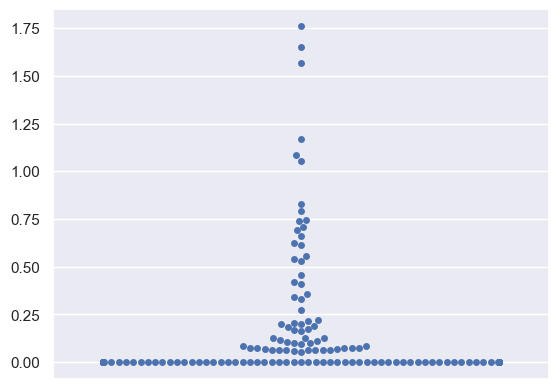

In [772]:
sns.swarmplot(p2cp)

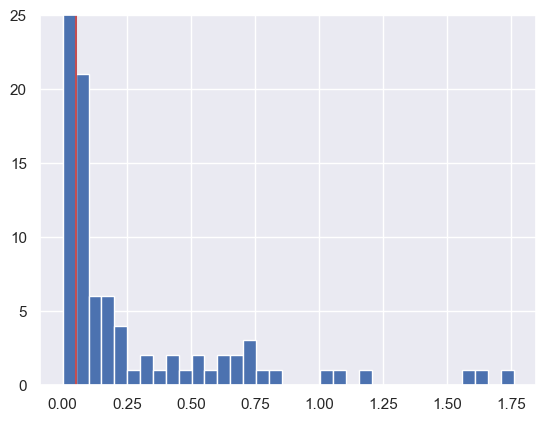

In [773]:
plt.hist(p2cp, bins = 35)
plt.ylim(0,25)
plt.vlines(0.05, 0,100, color = 'r')

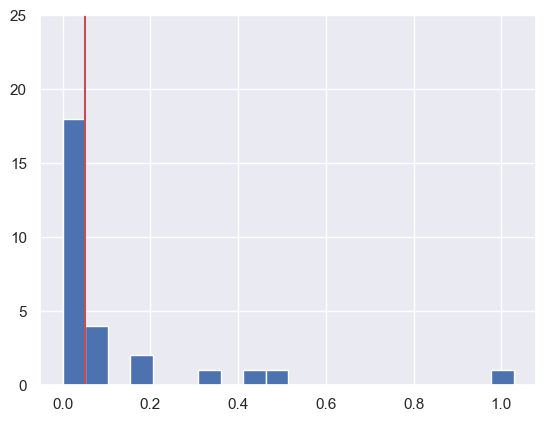

In [774]:
plt.hist(p2avgcp, bins = 20)
plt.ylim(0,25)
plt.vlines(0.05, 0,100, color = 'r')

In [776]:
for ele in p2avgs:
    print(ele)

0.16882013858011286
0.0
0.45757132432513736
0.0
0.0
0.09871397259798313
0.0
0.3554607887060227
0.06726762352158852
0.16779967795961923
0.0
0.0
0.0
0.0
0.0
0.49939754121457164
0.0
1.0280804138667807
0.0
0.0
0.08164758139744131
0.0
0.0
0.0
0.0
0.0
0.09386036742023417
0.0


---

In [933]:
i = 5

wave_dir = dirs[i]
#load every wave into a dictionary
waves = {}
for filename in os.listdir(wave_dir):
    waves[filename[filename.find("_")+1:-4]] = loadibw(wave_dir+"/"+str(filename))['wave']['wData'] #keeps only the waves
#convert into a nice structured dataframe
wavedata = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in waves.items()]))
boxcardata = wavedata.rolling(50).mean()
#is this even necessary? maybe to save into an addressable HDF5 file or with nwb format?

#digitization frequency (samples per millisecond)
freq = 50 #per ms (50 KHz)

print(dirs[i][-14:-6])

/091122K


In [934]:
two_pulse = protocolID(waves, twop = True)
len(two_pulse)

3

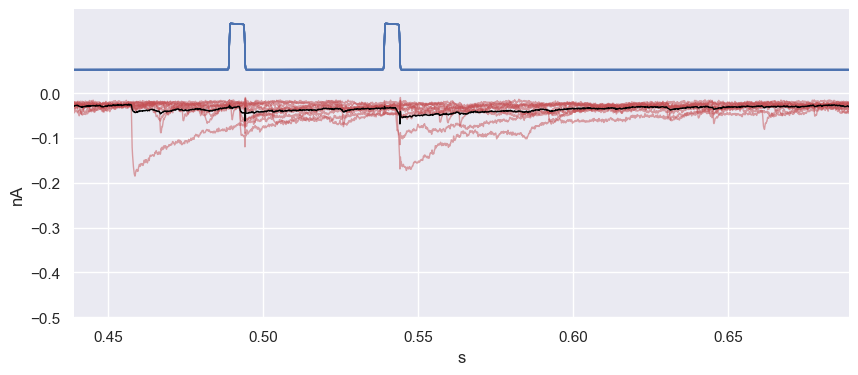

In [937]:
n = 0
avgplot(two_pulse[n], wavedata, autoscale = [50,150])
#avgplot(two_pulse[n], boxcardata, autoscale = [50,150])

# find peak amps by zscore

In [879]:
p1 = []
p2 = []
test = []
p1zs = []
p2zs = []
twop = protocolID(boxcardata, twop = True)
ele = twop[n]
for i in range(int(len(ele)/2)):
        amp = -1*amps(boxcardata[ele[i*2]],boxcardata[ele[i*2+1]])
        zss = zs(boxcardata[ele[i*2]],boxcardata[ele[i*2+1]])
        test += amp.tolist()
        p1 += [amp[0]]
        p2 += [amp[1]]
        p1zs += [zss[0]]
        p2zs += [zss[1]]
p1 = np.array(p1)
p2 = np.array(p2)
p1zs = np.array(p1zs)
p2zs = np.array(p2zs)

In [886]:
len(p2[p2>0.02])

2

In [880]:
print("# 1st Peaks above 3 zs: "+str(len(p1[np.abs(p1zs)>3])))
print("Average Amplitude of responses: "+str(np.around(np.mean(p1[np.abs(p1zs)>10])*1000,2))+"\n")

print("# 2nd Peaks above 3 zs: "+str(len(p2[np.abs(p2zs)>3])))
print("Average Amplitude of responses: "+str(np.around(np.mean(p2[np.abs(p2zs)>10])*1000,2)))

# 1st Peaks above 3 zs: 5
Average Amplitude of responses: 100.65

# 2nd Peaks above 3 zs: 4
Average Amplitude of responses: 50.14


In [529]:
print("Avg 1st window: "+str(np.around(np.mean(p1)*1000,2)))
print("Avg 2nd window: "+str(np.around(np.mean(p2)*1000,2)))

Avg 1st window: 8.78
Avg 2nd window: 4.73


(-0.005, 0.2)

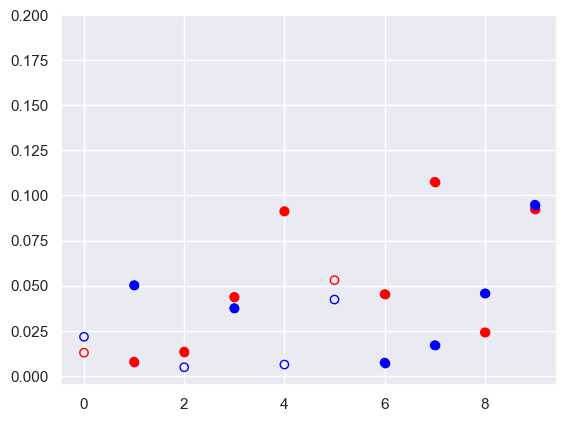

In [354]:
plt.scatter(np.arange(0,10,1),p1, facecolors='none', edgecolors='red')
p1c = np.copy(p1)
p1c[np.abs(p1zs)<3] = -10
plt.scatter(np.arange(0,10,1),p1c, color = 'red')

plt.scatter(np.arange(0,10,1),p2, facecolors='none', edgecolors='blue')
p2c = np.copy(p2)
p2c[np.abs(p2zs)<3] = -10
plt.scatter(np.arange(0,10,1),p2c, color = 'blue')
plt.ylim(-0.005,0.2)

In [360]:
n = 0
i = 1
print(twop[n][i])
waveplot(twop[n][i+1],twop[n][i], boxcardata, autoscale = [50,150])

1_11_10_2


KeyError: 0

In [94]:
print("0")
for i in range(len(p1)):
    print(p1[i])
    
print("\n\n")

print("0")
for i in range(len(p2)):
    print(p2[i])

print("\n\n")

for i in range(len(p2)+1):
    print(str(np.mean(p1[np.abs(p1zs)>10])))

print("\n\n")

for i in range(len(p2)+1):
    print(str(np.mean(p2[np.abs(p2zs)>10])))

print("\n\n")

for i in range(len(p2)):
    print(p1[i])
    print(p2[i])
    print()

print("\n\n")
for i in range(len(p2)+1):
    print(str(np.mean(p1)))

print("\n\n")
for i in range(len(p2)+1):
    print(str(np.mean(p2)))

0
0.0055361316
0.029186703
0.018352643
0.016457006
0.011364557
0.0030164123
0.009847701
0.0060325786
0.020885013
0.00985042



0
0.008755177
0.00836952
0.00833755
0.009841539
0.012316458
0.06577979
0.0071112514
0.02409742
0.007944562
0.014910944



nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan



nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan



0.0055361316
0.008755177

0.029186703
0.00836952

0.018352643
0.00833755

0.016457006
0.009841539

0.011364557
0.012316458

0.0030164123
0.06577979

0.009847701
0.0071112514

0.0060325786
0.02409742

0.020885013
0.007944562

0.00985042
0.014910944




0.013052916
0.013052916
0.013052916
0.013052916
0.013052916
0.013052916
0.013052916
0.013052916
0.013052916
0.013052916
0.013052916



0.01674642
0.01674642
0.01674642
0.01674642
0.01674642
0.01674642
0.01674642
0.01674642
0.01674642
0.01674642
0.01674642
